In [1]:
import os, sys
print(sys.executable) # works this time
print(sys.version)
print(sys.version_info)
import scanpy as sc
from sklearn.cross_decomposition import CCA
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix
from scipy.sparse import csr_matrix
import numpy as np
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import random

I:\mutiomics\pythonProject\.venv\Scripts\python.exe
3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
sys.version_info(major=3, minor=10, micro=11, releaselevel='final', serial=0)



KeyboardInterrupt



In [ ]:
adata1 = sc.read_h5ad("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\m3_9AA_VisiumArray.h5ad")
adata2 = sc.read_h5ad("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\m3_visium_9AA.h5ad")

In [4]:
adata1.obs["leiden"] = adata1.obs["clusters"]
adata2.obs["leiden"] = adata2.obs["clusters"]
idx_to_remove = adata1.obs["clusters"][adata1.obs["clusters"] == "0"]
keep_cells_mask = ~adata1.obs.index.isin(idx_to_remove.index)
adata1 = adata1[keep_cells_mask, :]
print(adata2)
print(adata1)
print(idx_to_remove.index)

AnnData object with n_obs × n_vars = 2220 × 15630
    obs: 'in_tissue', 'array_row', 'array_col', 'mt_frac', 'total_counts', 'n_counts', 'n_genes', 'clusters', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 3084 × 3658
    obs: 'clusters', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '5090', '5091', '5092', '5093', '5094', '5095', '5096', '5097', '5098',
       '5099'],
      dtype='object', 

[<Axes: title={'center': 'clusters'}, xlabel='spatial1', ylabel='spatial2'>]

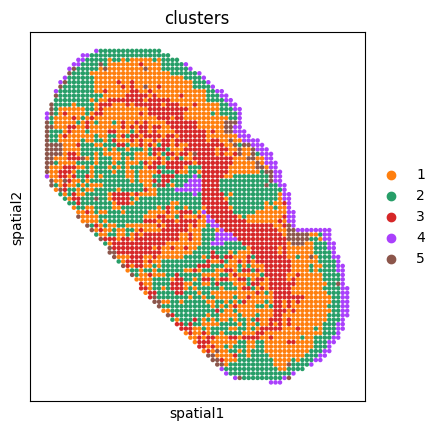

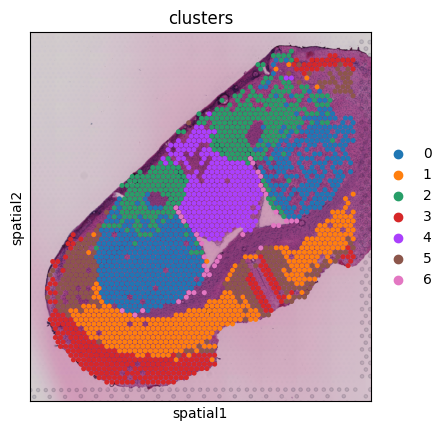

In [5]:
import matplotlib.pyplot as plt
sc.pl.spatial(adata1, img_key = "hires", color="clusters", spot_size=1, show=False)
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\m3_9AA_VisiumArray_plot.pdf")
sc.pl.spatial(adata2, img_key = "hires", color="clusters", size=1.5, show=False)
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\m3_visium_ctrl.pdf")

In [6]:
data1_pca_results = adata1.obsm['spatial']  # PCA 结果
pca_leiden = adata1.obs["leiden"]
data1_leiden_str = pca_leiden.to_numpy()

data2_pca_results = adata2.obsm['X_umap']  # PCA 结果
pca_leiden = adata2.obs["leiden"]
data2_leiden_str = pca_leiden.to_numpy()

def var_select(df, m1, m2, n):
    # 1. 筛选出列均值在 m1 和 m2 之间的行
    filtered_df = df.loc[:,(df.mean() > m1) & (df.mean() < m2)]

    # 2. 计算每行的方差，并选择前 n 个最大值所对应的索引
    variances = filtered_df.var(axis=0)/filtered_df.mean()
    sorted_indices = variances.sort_values(ascending=False).index
    selected_indices = sorted_indices[:n]

    return selected_indices.tolist()


def convert_to_array(x):
    if isinstance(x, csr_matrix):
        return x.toarray()
    elif isinstance(x, np.ndarray):
        return x
    else:
        raise ValueError("Unsupported input type. Must be csr_matrix or ndarray.")
        
def tpm_normalize(counts_matrix):
    # 计算每个细胞的总表达量
    total_counts_per_cell = counts_matrix.sum(axis=1)
    # 计算每个基因的 TPM
    tpm_matrix = (counts_matrix.div(total_counts_per_cell, axis=0)) * 1e4
    return tpm_matrix

In [7]:
##first select random 2200 indices
selected_indices = np.random.choice(3084, 2220, replace=False)
X1_label=adata1.obs["leiden"].to_numpy()[selected_indices].astype(int)
X1_label[X1_label == 2] = 10
X1_label[X1_label == 1] = 11
# 将除了12和13之外的所有值都替换为100
X1_label[~np.isin(X1_label, [10,11])] = 12
print(X1_label)
X3_label = adata1.obs["leiden"].to_numpy().astype(int)
X3_label[X3_label == 2] = 10
X3_label[X3_label == 1] = 11
# 将除了12和13之外的所有值都替换为100
X3_label[~np.isin(X3_label, [10,11])] = 12

X2_label = adata2.obs["leiden"].to_numpy().astype(int)
X2_label[X2_label == 0] = 10
X2_label[X2_label == 1] = 11
# 将除了12和13之外的所有值都替换为100
X2_label[~np.isin(X2_label, [10,11])] = 12

[10 12 12 ... 12 12 12]


In [8]:
#####spatial alignment of data3(metabolic) and data2(spatial) using CCA
def rotate_point_90_degrees(row):
    new_x = -row[0]
    new_y = row[1]
    return pd.Series({0: new_x, 1: new_y})

def flip_around_y_minus_x(row):
    new_x = -row[0]
    new_y = -row[1]
    return pd.Series({0: new_x, 1: new_y})

def flip_around_y_plus_x(row):
    new_x = row[1]
    new_y = row[0]
    return pd.Series({0: new_x, 1: new_y})

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-100, 100))
selected_indices = np.random.choice(range(3084), 2220, replace=False)
data3_spatial_results = pd.DataFrame(adata1.obsm['spatial'])
scaled_data = scaler.fit_transform(data3_spatial_results)
data3_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
print(data3_spatial_results.head)
data2_spatial_results = pd.DataFrame(adata2.obsm['spatial'])
scaled_data = scaler.fit_transform(data2_spatial_results)
data2_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)

data2_spatial_results=pd.DataFrame(data2_spatial_results)
data3_spatial_results=pd.DataFrame(data3_spatial_results)
data3_spatial_results = data3_spatial_results.apply(rotate_point_90_degrees, axis=1)
data3_spatial_results = data3_spatial_results.apply(flip_around_y_minus_x, axis=1)
data3_spatial_results = data3_spatial_results.apply(flip_around_y_plus_x, axis=1)
data1_spatial_results = data3_spatial_results.iloc[selected_indices,:]
data1_spatial_results=pd.DataFrame(data1_spatial_results)
data1_spatial_results = data1_spatial_results +100
data2_spatial_results = data2_spatial_results +100
data3_spatial_results = data3_spatial_results +100

<bound method NDFrame.head of           0          1
0    -100.0 -62.162162
1    -100.0 -59.459459
2    -100.0 -56.756757
3    -100.0 -54.054054
4    -100.0 -51.351351
...     ...        ...
3079  100.0  48.648649
3080  100.0  51.351351
3081  100.0  54.054054
3082  100.0  56.756757
3083  100.0  59.459459

[3084 rows x 2 columns]>


C:\Users\28123\AppData\Local\Temp\ipykernel_12340\4081012610.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colormap)


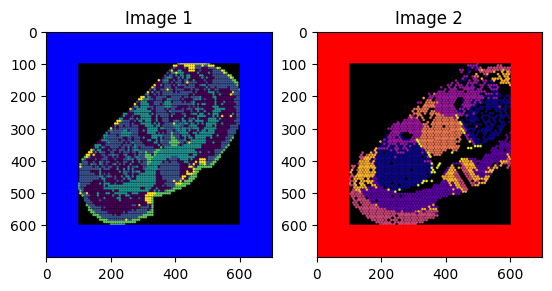

Transformation Matrix:
 [[ 8.39242385e-01 -2.37727156e-02  1.73327873e+01]
 [-1.44253903e-01  8.03276171e-01  1.12905042e+02]]


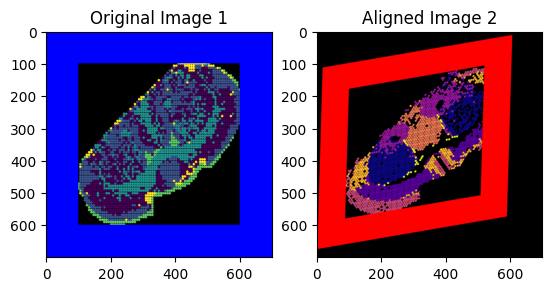

               0           1             2
0     114.270963   98.216175  17070.943194
1      -6.313025  121.180355  17415.105588
2     116.909503   20.442883   5858.976000
3     134.547021   86.829960  15921.958081
4      12.956752   83.924551  12490.057339
...          ...         ...           ...
2215   86.348464   58.031338  10552.684480
2216   26.522486  118.055418  17774.999422
2217    8.818886  122.891038  18037.828764
2218   10.389149   90.475008  13376.313391
2219   19.307864  150.644142  22321.799933

[2220 rows x 3 columns]
               0      1
0     162.162162    0.0
1     159.459459    0.0
2     156.756757    0.0
3     154.054054    0.0
4     151.351351    0.0
...          ...    ...
3079   51.351351  200.0
3080   48.648649  200.0
3081   45.945946  200.0
3082   43.243243  200.0
3083   40.540541  200.0

[3084 rows x 2 columns]
               0           1             2
0     114.270963   98.216175  17070.943194
1      -6.313025  121.180355  17415.105588
2     116.909503 

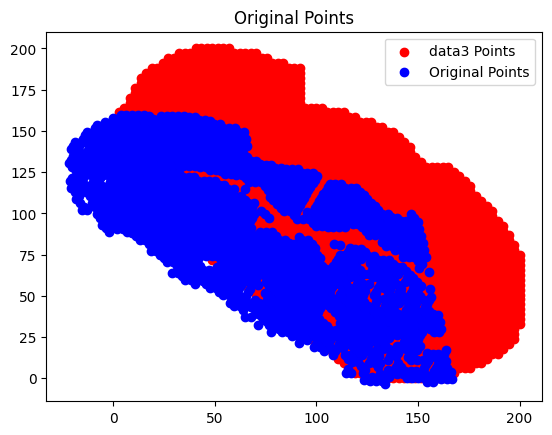

In [9]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def create_image_from_data(data, width=500, height=500, dot_size=5, border_size=50, dot_colors=None, border_color=(0, 0, 0), colormap='viridis'):
    """
    Create an image from 2D data points with specified dot size, border size, and colors.

    Parameters:
    - data: 2D numpy array where data[0] contains x coordinates and data[1] contains y coordinates
    - width: Width of the image
    - height: Height of the image
    - dot_size: Size of the dots
    - border_size: Size of the border around the image
    - dot_colors: List of scalar values for each dot, which will be mapped to colors using a colormap
    - border_color: Color of the border (BGR format)
    - colormap: Colormap to use for mapping scalar values to colors
    
    Returns:
    - bordered_image: Image with data points and border
    """
    # Initialize an empty image with three channels for color
    image = np.zeros((height, width, 3), dtype=np.uint8)

    # Normalize data points to image dimensions
    x_norm = np.interp(data[0], (data[0].min(), data[0].max()), (0, width-1))
    y_norm = np.interp(data[1], (data[1].min(), data[1].max()), (0, height-1))

    # Normalize dot_colors to [0, 1] range
    if dot_colors is not None:
        norm = plt.Normalize(vmin=min(dot_colors), vmax=max(dot_colors))
        cmap = cm.get_cmap(colormap)
        mapped_colors = cmap(norm(dot_colors))

    # Draw circles at normalized positions
    for i, (x, y) in enumerate(zip(x_norm, y_norm)):
        if dot_colors is not None:
            color = (mapped_colors[i][:3] * 255).astype(int)  # Convert to BGR format
            color = tuple(map(int, color[::-1]))  # Convert from RGB to BGR
        else:
            color = (255, 255, 255)  # Default white color
        cv2.circle(image, (int(x), int(y)), dot_size, color, -1)  # -1 means filled circle

    # Add border
    bordered_image = cv2.copyMakeBorder(image, border_size, border_size, border_size, border_size, 
                                        cv2.BORDER_CONSTANT, value=border_color)

    return bordered_image

# Simulated scalar values
dot_colors_1 = data1_leiden_str.astype(int)
dot_colors_2 = data2_leiden_str.astype(int)

# Create images
img1 = create_image_from_data(data3_spatial_results, width=500, height=500, dot_size=4, border_size=100, dot_colors=dot_colors_1, border_color=(255, 0, 0), colormap='viridis')
img2 = create_image_from_data(data2_spatial_results, width=500, height=500, dot_size=4, border_size=100, dot_colors=dot_colors_2, border_color=(0, 0, 255), colormap='plasma')

# Display images using matplotlib
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Image 1')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Image 2')

plt.show()


import cv2
import numpy as np
import matplotlib.pyplot as plt

# Lists to store points
points_image1 = []
points_image2 = []

def click_event_image1(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points_image1.append((x, y))
        cv2.circle(img1_display, (x, y), 5, (0, 255, 0), -1)
        cv2.imshow('Image 1', img1_display)

def click_event_image2(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points_image2.append((x, y))
        cv2.circle(img2_display, (x, y), 5, (0, 255, 0), -1)
        cv2.imshow('Image 2', img2_display)

def compute_affine_transform(points_image1, points_image2):
    pts1 = np.float32(points_image1)
    pts2 = np.float32(points_image2)
    M = cv2.getAffineTransform(pts2[:3], pts1[:3])  # Use the first 3 points for affine transform
    return M

def warp_image(image, M, output_shape):
    warped_image = cv2.warpAffine(image, M, output_shape)
    return warped_image

# Load images
img1_display = img1.copy()
img2_display = img2.copy()

# Display images and set mouse callbacks
cv2.imshow('Image 1', img1_display)
cv2.imshow('Image 2', img2_display)
cv2.setMouseCallback('Image 1', click_event_image1)
cv2.setMouseCallback('Image 2', click_event_image2)

# Wait until 6 points are selected (3 from each image)
while len(points_image1) < 3 or len(points_image2) < 3:
    cv2.waitKey(1)

cv2.destroyAllWindows()

# Compute the transformation matrix
M = compute_affine_transform(points_image1, points_image2)
print("Transformation Matrix:\n", M)

# Apply the transformation to the second image
rows, cols = img1.shape[:2]
aligned_image = warp_image(img2, M, (cols, rows))

# Display the original and aligned images
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Original Image 1')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB))
plt.title('Aligned Image 2')
plt.show()

M_homogeneous = np.vstack([M, [0, 0, 1]])

# Convert DataFrame to homogeneous coordinates
coordinates_data3 = data3_spatial_results  # Add a column of 1s
coordinates_data2 = data2_spatial_results  # Add a column of 1s

# Apply the transformation matrix
#transformed_coordinates_data3 = coordinates_data3.dot(M_homogeneous.T)
transformed_coordinates_data2 = coordinates_data2.dot(M)
# Update the DataFrame with the transformed coordinates
print(transformed_coordinates_data2)
print(data3_spatial_results)
plt.title('Original Points')
plt.scatter(data3_spatial_results[0], data3_spatial_results[1], color='red', label='data3 Points')
plt.scatter(transformed_coordinates_data2[0], transformed_coordinates_data2[1], color='blue', label='Original Points')


plt.legend()

print(transformed_coordinates_data2)
data2_spatial_results = transformed_coordinates_data2.iloc[:,0:2]
print(data2_spatial_results)

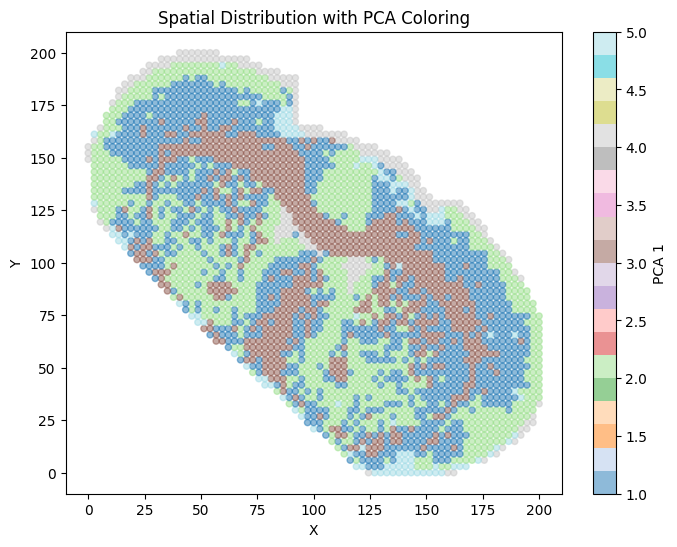

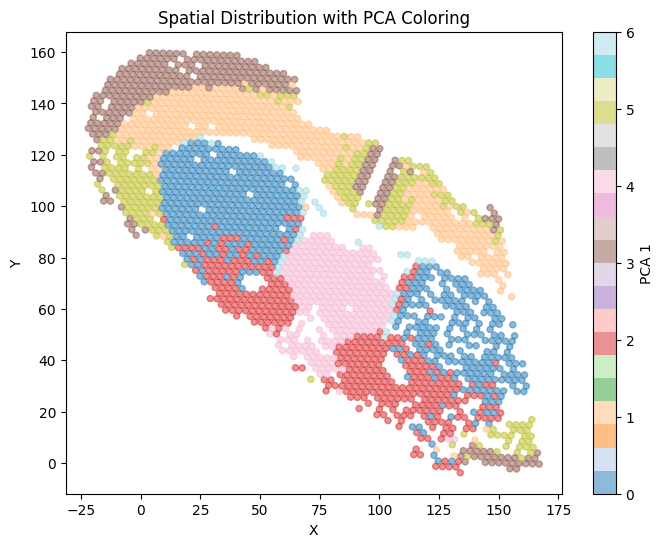

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1], c=data1_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\m3_spatial_CCA.pdf")
plt.figure(figsize=(8, 6))
plt.scatter(data2_spatial_results.iloc[:, 0], data2_spatial_results.iloc[:, 1], c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\m3_metabolic_CCA.pdf")

In [11]:
##############select nearst indices
import random
selected_indices = np.random.choice(3084, 2220, replace=False)
def func1(selected_indices):
    X1_label=adata1.obs["leiden"].to_numpy()[selected_indices].astype(int)
    X1_label[X1_label == 2] = 10
    X1_label[X1_label == 1] = 11
    # 将除了12和13之外的所有值都替换为100
    X1_label[~np.isin(X1_label, [10,11])] = 12
    X3_label = adata1.obs["leiden"].to_numpy().astype(int)
    X3_label[X3_label == 2] = 10
    X3_label[X3_label == 1] = 11
    # 将除了12和13之外的所有值都替换为100
    X3_label[~np.isin(X3_label, [10,11])] = 12
    X2_label = adata2.obs["leiden"].to_numpy().astype(int)
    X2_label[X2_label == 0] = 10
    X2_label[X2_label == 1] = 11
# 将除了12和13之外的所有值都替换为100
    X2_label[~np.isin(X2_label, [10,11])] = 12

    scaler = MinMaxScaler(feature_range=(-1, 1))

    data3_spatial_results = pd.DataFrame(adata1.obsm['spatial'])
    scaled_data = scaler.fit_transform(data3_spatial_results)
    data3_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
    data1_spatial_results = data3_spatial_results.iloc[selected_indices,:]
    data2_spatial_results = pd.DataFrame(adata2.obsm['spatial'])
    scaled_data = scaler.fit_transform(data2_spatial_results)
    data2_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
    data1_spatial_results=pd.DataFrame(data1_spatial_results)
    data2_spatial_results=pd.DataFrame(data2_spatial_results)
    data3_spatial_results=pd.DataFrame(data3_spatial_results)
    data3_spatial_results = data3_spatial_results.apply(rotate_point_90_degrees, axis=1)
    data3_spatial_results = data3_spatial_results.apply(flip_around_y_minus_x, axis=1)
    data3_spatial_results = data3_spatial_results.apply(flip_around_y_plus_x, axis=1)

    
    scaler = MinMaxScaler(feature_range=(-1, 1))
    X_data3 = convert_to_array(adata1.X)
    X_data3 = pd.DataFrame(X_data3)
    X_data3 = scaler.fit_transform(X_data3)
    X_data3 = pd.DataFrame(X_data3)
    high_variance_variables = var_select(X_data3,-100,4000000, 500)
    X_data3 = X_data3.iloc[:,high_variance_variables]
    pca = PCA()
# 对数据进行 PCA
    X3_pca = pca.fit_transform(X_data3)
    umap_model = umap.UMAP(n_components=2, random_state=42)
    X_3_umap_results = pd.DataFrame(umap_model.fit_transform(X3_pca))
    scaled_data = scaler.fit_transform(X_3_umap_results)
    X_3_umap_results = pd.DataFrame(scaled_data, columns=X_3_umap_results.columns)
    X_3_umap_results[2] = X3_label
    X_3_umap_results[3] = pd.DataFrame(data3_spatial_results).iloc[:,0].to_numpy()
    X_3_umap_results[4] = pd.DataFrame(data3_spatial_results).iloc[:,1].to_numpy()
    #X3_tsne = TSNE(n_components=3,perplexity=10, random_state=42).fit_transform(X3_pca[:,0:30])

    X_1_umap_results = X_3_umap_results.iloc[selected_indices,]


    X_data2 = convert_to_array(adata2.X)
    X_data2 = pd.DataFrame(X_data2)
    X_data2 = tpm_normalize(X_data2)
    X_data2 = np.log2(X_data2 + 1)
    X_data2 = pd.DataFrame(X_data2)
    high_variance_variables = var_select(X_data2,0.01,40 ,2000)
    X_data2 = X_data2.iloc[:,high_variance_variables]
    #X_data2 = scaler.fit_transform(X_data2)
    pca = PCA()
    # 对数据进行 PCA
    X2_pca = pca.fit_transform(X_data2)
    umap_model = umap.UMAP(n_components=2, random_state=42)
    X_2_umap_results = pd.DataFrame(umap_model.fit_transform(X2_pca[:, 0:30]))
    #X_2_umap_results = pd.DataFrame(adata2.obsm["X_umap"])
    scaled_data = scaler.fit_transform(X_2_umap_results)
    X_2_umap_results = pd.DataFrame(scaled_data, columns=X_2_umap_results.columns)
    #X2_tsne = TSNE(n_components=3,perplexity=10, random_state=42).fit_transform(X2_pca[:,0:30])
    X_2_umap_results[2] = X2_label
    X_2_umap_results[3] = pd.DataFrame(data2_spatial_results).iloc[:,0].to_numpy()
    X_2_umap_results[4] = pd.DataFrame(data2_spatial_results).iloc[:,1].to_numpy()
    cca = CCA(n_components=2)
    cca.fit(X_1_umap_results,X_2_umap_results)
    X_c = cca.transform(X_1_umap_results)
    Y_c = cca.transform(X_2_umap_results)
    Z_c = cca.transform(X_3_umap_results)

    X_c=pd.DataFrame(X_c)
    Y_c=pd.DataFrame(Y_c)
    Z_c=pd.DataFrame(Z_c)

    dist_min = 0.05 ## min euclidean distance
    from scipy.spatial.distance import cdist
    distances = cdist(Z_c, Y_c, metric='euclidean')
    dist_df = pd.DataFrame(distances)
    dt_describe = dist_df.describe()
    ###############找出Y_C(spatial)周围dist_min以内的Z_C(metabolic)点
    row_indices, col_indices = np.where(distances <dist_min)
    unique_row_indices = np.unique(row_indices)
    return unique_row_indices

def sample_and_apply(input_array,n,m):
    m = m
    output_array = []
    elements = list(input_array)  # 生成包含所有元素的列表
    
    while m > -1:  # 当列表不为空时循环
        random.shuffle(elements)  # 随机洗牌
        sample = elements[:n]  # 从列表中随机抽取 n 个元素
        output_array.append(func1(sample))  # 将输出值存储在新数组中
        m = m-1
    return output_array
output_array = sample_and_apply(range(3084), 2220,-1)
print("select indice finished")


select indice finished


In [12]:
print(len(output_array))
array_lengths = [len(arr) for arr in output_array]
# 打印每个数组的长度
for i, length in enumerate(array_lengths):
    print("Length of array", i+1, ":", length)
merged_array = np.concatenate(output_array)
merged_array = np.unique(merged_array)
print(len(merged_array))

0


ValueError: need at least one array to concatenate

In [13]:
###casual run using neasrst indices
selected_indices = np.random.choice(range(3084), 2220, replace=False)
X1_label=adata1.obs["leiden"].to_numpy()[selected_indices].astype(int)
X1_label[X1_label == 2] = 10
X1_label[X1_label == 1] = 11
# 将除了12和13之外的所有值都替换为100
X1_label[~np.isin(X1_label, [10,11])] = 12
print(X1_label)
X3_label = adata1.obs["leiden"].to_numpy().astype(int)
X3_label[X3_label == 2] = 10
X3_label[X3_label == 1] = 11
# 将除了12和13之外的所有值都替换为100
X3_label[~np.isin(X3_label, [10,11])] = 12

X2_label = adata2.obs["leiden"].to_numpy().astype(int)
X2_label[X2_label == 0] = 10
X2_label[X2_label == 1] = 11
# 将除了12和13之外的所有值都替换为100
X2_label[~np.isin(X2_label, [10,11])] = 12

[12 11 10 ... 11 11 11]


In [130]:


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-100, 100))
selected_indices = np.random.choice(range(3084), 2220, replace=False)
data3_spatial_results = pd.DataFrame(adata1.obsm['spatial'])
scaled_data = scaler.fit_transform(data3_spatial_results)
data3_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
print(data3_spatial_results.head)
data2_spatial_results = pd.DataFrame(adata2.obsm['spatial'])
scaled_data = scaler.fit_transform(data2_spatial_results)
data2_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)

data2_spatial_results=pd.DataFrame(data2_spatial_results)
data3_spatial_results=pd.DataFrame(data3_spatial_results)
data3_spatial_results = data3_spatial_results.apply(rotate_point_90_degrees, axis=1)
data3_spatial_results = data3_spatial_results.apply(flip_around_y_minus_x, axis=1)
data3_spatial_results = data3_spatial_results.apply(flip_around_y_plus_x, axis=1)
data1_spatial_results = data3_spatial_results.iloc[selected_indices,:]
data1_spatial_results=pd.DataFrame(data1_spatial_results)
data1_spatial_results = data1_spatial_results +100
data2_spatial_results = data2_spatial_results +100
data3_spatial_results = data3_spatial_results +100

<bound method NDFrame.head of           0          1
0    -100.0 -62.162162
1    -100.0 -59.459459
2    -100.0 -56.756757
3    -100.0 -54.054054
4    -100.0 -51.351351
...     ...        ...
3079  100.0  48.648649
3080  100.0  51.351351
3081  100.0  54.054054
3082  100.0  56.756757
3083  100.0  59.459459

[3084 rows x 2 columns]>


C:\Users\28123\AppData\Local\Temp\ipykernel_12340\526568848.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colormap)


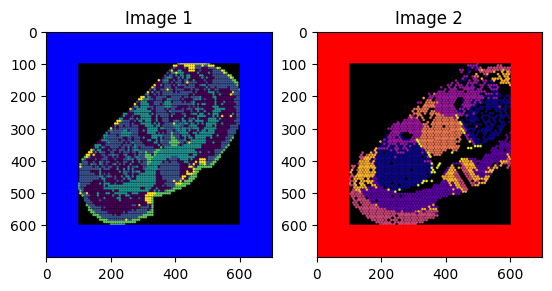

Transformation Matrix:
 [[ 8.47714851e-01  1.25991310e-02  3.43239172e-01]
 [-1.29477236e-02  9.50711502e-01  1.86315377e+01]]


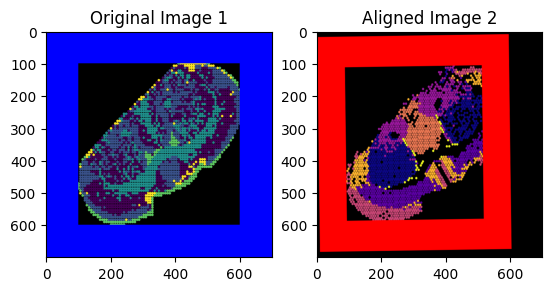

               0           1            2
0     132.278085  122.678345  2419.402760
1      13.724174  144.175790  2827.262617
2     122.035878   30.077692   603.357576
3     150.962756  110.091712  2174.839898
4      27.090181  100.695658  1976.613383
...          ...         ...          ...
2215   97.266748   73.403587  1449.688423
2216   46.526564  142.051834  2789.361845
2217   29.364233  146.953671  2883.483206
2218   25.572744  108.380528  2127.056869
2219   44.618840  180.555514  3543.779305

[2220 rows x 3 columns]
               0      1
0     162.162162    0.0
1     159.459459    0.0
2     156.756757    0.0
3     154.054054    0.0
4     151.351351    0.0
...          ...    ...
3079   51.351351  200.0
3080   48.648649  200.0
3081   45.945946  200.0
3082   43.243243  200.0
3083   40.540541  200.0

[3084 rows x 2 columns]


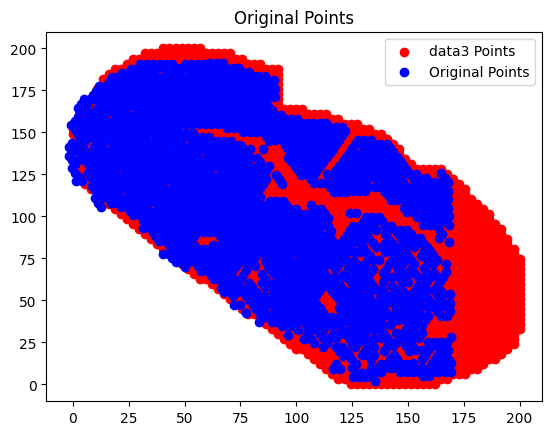

In [132]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def create_image_from_data(data, width=500, height=500, dot_size=5, border_size=50, dot_colors=None, border_color=(0, 0, 0), colormap='viridis'):
    """
    Create an image from 2D data points with specified dot size, border size, and colors.

    Parameters:
    - data: 2D numpy array where data[0] contains x coordinates and data[1] contains y coordinates
    - width: Width of the image
    - height: Height of the image
    - dot_size: Size of the dots
    - border_size: Size of the border around the image
    - dot_colors: List of scalar values for each dot, which will be mapped to colors using a colormap
    - border_color: Color of the border (BGR format)
    - colormap: Colormap to use for mapping scalar values to colors
    
    Returns:
    - bordered_image: Image with data points and border
    """
    # Initialize an empty image with three channels for color
    image = np.zeros((height, width, 3), dtype=np.uint8)

    # Normalize data points to image dimensions
    x_norm = np.interp(data[0], (data[0].min(), data[0].max()), (0, width-1))
    y_norm = np.interp(data[1], (data[1].min(), data[1].max()), (0, height-1))

    # Normalize dot_colors to [0, 1] range
    if dot_colors is not None:
        norm = plt.Normalize(vmin=min(dot_colors), vmax=max(dot_colors))
        cmap = cm.get_cmap(colormap)
        mapped_colors = cmap(norm(dot_colors))

    # Draw circles at normalized positions
    for i, (x, y) in enumerate(zip(x_norm, y_norm)):
        if dot_colors is not None:
            color = (mapped_colors[i][:3] * 255).astype(int)  # Convert to BGR format
            color = tuple(map(int, color[::-1]))  # Convert from RGB to BGR
        else:
            color = (255, 255, 255)  # Default white color
        cv2.circle(image, (int(x), int(y)), dot_size, color, -1)  # -1 means filled circle

    # Add border
    bordered_image = cv2.copyMakeBorder(image, border_size, border_size, border_size, border_size, 
                                        cv2.BORDER_CONSTANT, value=border_color)

    return bordered_image

# Simulated scalar values
dot_colors_1 = data1_leiden_str.astype(int)
dot_colors_2 = data2_leiden_str.astype(int)

# Create images
img1 = create_image_from_data(data3_spatial_results, width=500, height=500, dot_size=4, border_size=100, dot_colors=dot_colors_1, border_color=(255, 0, 0), colormap='viridis')
img2 = create_image_from_data(data2_spatial_results, width=500, height=500, dot_size=4, border_size=100, dot_colors=dot_colors_2, border_color=(0, 0, 255), colormap='plasma')

# Display images using matplotlib
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Image 1')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Image 2')

plt.show()


import cv2
import numpy as np
import matplotlib.pyplot as plt

# Lists to store points
points_image1 = []
points_image2 = []

def click_event_image1(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points_image1.append((x, y))
        cv2.circle(img1_display, (x, y), 5, (0, 255, 0), -1)
        cv2.imshow('Image 1', img1_display)

def click_event_image2(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points_image2.append((x, y))
        cv2.circle(img2_display, (x, y), 5, (0, 255, 0), -1)
        cv2.imshow('Image 2', img2_display)

def compute_affine_transform(points_image1, points_image2):
    pts1 = np.float32(points_image1)
    pts2 = np.float32(points_image2)
    M = cv2.getAffineTransform(pts2[:3], pts1[:3])  # Use the first 3 points for affine transform
    return M

def warp_image(image, M, output_shape):
    warped_image = cv2.warpAffine(image, M, output_shape)
    return warped_image

# Load images
img1_display = img1.copy()
img2_display = img2.copy()

# Display images and set mouse callbacks
cv2.imshow('Image 1', img1_display)
cv2.imshow('Image 2', img2_display)
cv2.setMouseCallback('Image 1', click_event_image1)
cv2.setMouseCallback('Image 2', click_event_image2)

# Wait until 6 points are selected (3 from each image)
while len(points_image1) < 3 or len(points_image2) < 3:
    cv2.waitKey(1)

cv2.destroyAllWindows()

# Compute the transformation matrix
M = compute_affine_transform(points_image1, points_image2)
print("Transformation Matrix:\n", M)

# Apply the transformation to the second image
rows, cols = img1.shape[:2]
aligned_image = warp_image(img2, M, (cols, rows))

# Display the original and aligned images
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Original Image 1')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB))
plt.title('Aligned Image 2')
plt.show()

M_homogeneous = np.vstack([M, [0, 0, 1]])

# Convert DataFrame to homogeneous coordinates
coordinates_data3 = data3_spatial_results  # Add a column of 1s
coordinates_data2 = data2_spatial_results  # Add a column of 1s

# Apply the transformation matrix
#transformed_coordinates_data3 = coordinates_data3.dot(M_homogeneous.T)
transformed_coordinates_data2 = coordinates_data2.dot(M)
# Update the DataFrame with the transformed coordinates
print(transformed_coordinates_data2)
print(data3_spatial_results)
plt.title('Original Points')
plt.scatter(data3_spatial_results[0], data3_spatial_results[1], color='red', label='data3 Points')
plt.scatter(transformed_coordinates_data2[0], transformed_coordinates_data2[1], color='blue', label='Original Points')


plt.legend()


In [133]:

print(transformed_coordinates_data2)
data2_spatial_results = transformed_coordinates_data2.iloc[:,0:2]
print(data2_spatial_results)

               0           1            2
0     132.278085  122.678345  2419.402760
1      13.724174  144.175790  2827.262617
2     122.035878   30.077692   603.357576
3     150.962756  110.091712  2174.839898
4      27.090181  100.695658  1976.613383
...          ...         ...          ...
2215   97.266748   73.403587  1449.688423
2216   46.526564  142.051834  2789.361845
2217   29.364233  146.953671  2883.483206
2218   25.572744  108.380528  2127.056869
2219   44.618840  180.555514  3543.779305

[2220 rows x 3 columns]
               0           1
0     132.278085  122.678345
1      13.724174  144.175790
2     122.035878   30.077692
3     150.962756  110.091712
4      27.090181  100.695658
...          ...         ...
2215   97.266748   73.403587
2216   46.526564  142.051834
2217   29.364233  146.953671
2218   25.572744  108.380528
2219   44.618840  180.555514

[2220 rows x 2 columns]


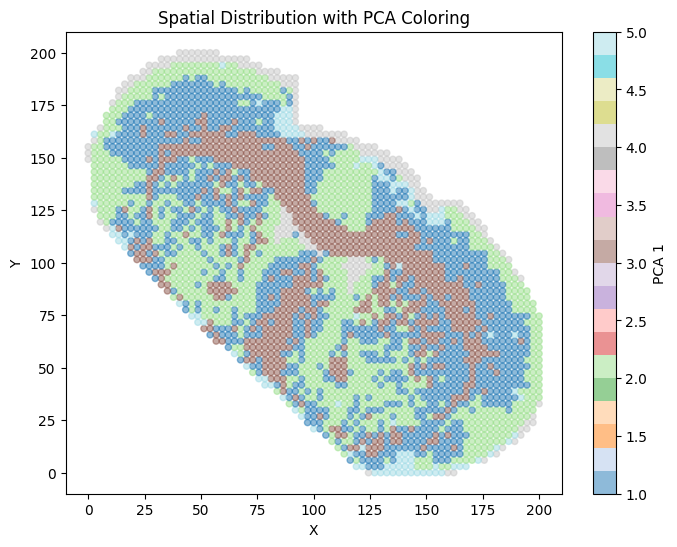

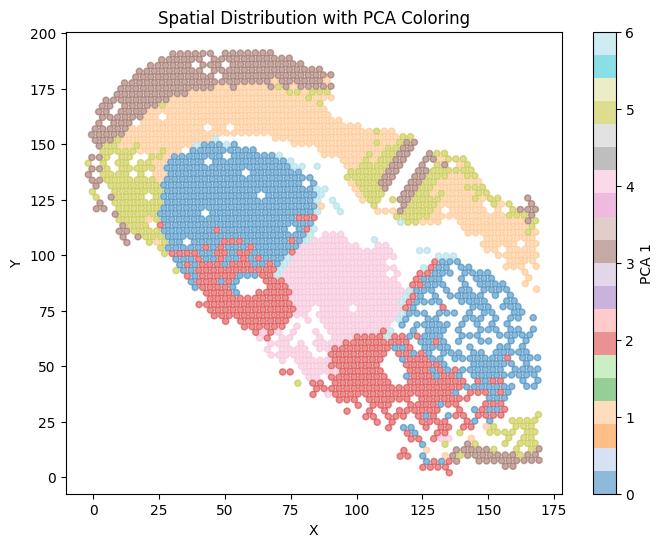

In [134]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1], c=data1_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(data2_spatial_results.iloc[:, 0], data2_spatial_results.iloc[:, 1], c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()

In [135]:
#####X1:metabolic subgroup 
#####X2:spatial 
#####X3:metabolic whole group
#####normalize, pca and umap of X1,X2 and X3
#####perform CCA between X1 and X2
#####fit CCA model to X1 X2 X3



pca_leiden = adata1.obs["leiden"]
data1_leiden_str = pca_leiden.to_numpy()
pca_leiden = adata2.obs["leiden"]
data2_leiden_str = pca_leiden.to_numpy()
scaler = MinMaxScaler(feature_range=(-1, 1))

#print(X_1_umap_results.head)
print(pd.DataFrame(adata1.obsm['spatial']).iloc[selected_indices,0])
X_data3 = convert_to_array(adata1.X)
X_data3 = pd.DataFrame(X_data3)
X_data3 = scaler.fit_transform(X_data3)
X_data3 = pd.DataFrame(X_data3)
high_variance_variables = var_select(X_data3,-100,40000, 500)
X_data3 = X_data3.iloc[:,high_variance_variables]
pca = PCA()
# 对数据进行 PCA
X3_pca = pca.fit_transform(X_data3)
umap_model = umap.UMAP(n_components=2, random_state=42)
X_3_umap_results = pd.DataFrame(umap_model.fit_transform(X3_pca))
scaled_data = scaler.fit_transform(X_3_umap_results)
X_3_umap_results = pd.DataFrame(scaled_data, columns=X_3_umap_results.columns)
X_3_umap_results[2] = X3_label
X_3_umap_results[3] = pd.DataFrame(data3_spatial_results).iloc[:,0].to_numpy()
X_3_umap_results[4] = pd.DataFrame(data3_spatial_results).iloc[:,1].to_numpy()
#X3_tsne = TSNE(n_components=3,perplexity=10, random_state=42).fit_transform(X3_pca[:,0:30])

X_1_umap_results = X_3_umap_results.iloc[selected_indices,]


X_data2 = convert_to_array(adata2.X)
X_data2 = pd.DataFrame(X_data2)
X_data2 = tpm_normalize(X_data2)
X_data2 = np.log2(X_data2 + 1)
X_data2 = pd.DataFrame(X_data2)
high_variance_variables = var_select(X_data2,0.01,40 ,2000)
X_data2 = X_data2.iloc[:,high_variance_variables]
#X_data2 = scaler.fit_transform(X_data2)
pca = PCA()
# 对数据进行 PCA
X2_pca = pca.fit_transform(X_data2)
umap_model = umap.UMAP(n_components=2, random_state=42)
X_2_umap_results = pd.DataFrame(umap_model.fit_transform(X2_pca[:, 0:30]))
#X_2_umap_results = pd.DataFrame(adata2.obsm["X_umap"])
scaled_data = scaler.fit_transform(X_2_umap_results)
X_2_umap_results = pd.DataFrame(scaled_data, columns=X_2_umap_results.columns)
#X2_tsne = TSNE(n_components=3,perplexity=10, random_state=42).fit_transform(X2_pca[:,0:30])
X_2_umap_results[2] = X2_label
X_2_umap_results[3] = pd.DataFrame(data2_spatial_results).iloc[:,0].to_numpy()
X_2_umap_results[4] = pd.DataFrame(data2_spatial_results).iloc[:,1].to_numpy()
cca = CCA(n_components=2)
cca.fit(X_1_umap_results,X_2_umap_results)
X_c = cca.transform(X_1_umap_results)
Y_c = cca.transform(X_2_umap_results)
Z_c = cca.transform(X_3_umap_results)

X_c=pd.DataFrame(X_c)
Y_c=pd.DataFrame(Y_c)
Z_c=pd.DataFrame(Z_c)

831     21
1154    27
3011    63
3023    64
1764    37
        ..
1924    39
1095    26
2764    55
1884    39
2364    47
Name: 0, Length: 2220, dtype: int64


I:\mutiomics\pythonProject\.venv\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
I:\mutiomics\pythonProject\.venv\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


I:\mutiomics\pythonProject\.venv\lib\site-packages\matplotlib\collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(2220, 2)


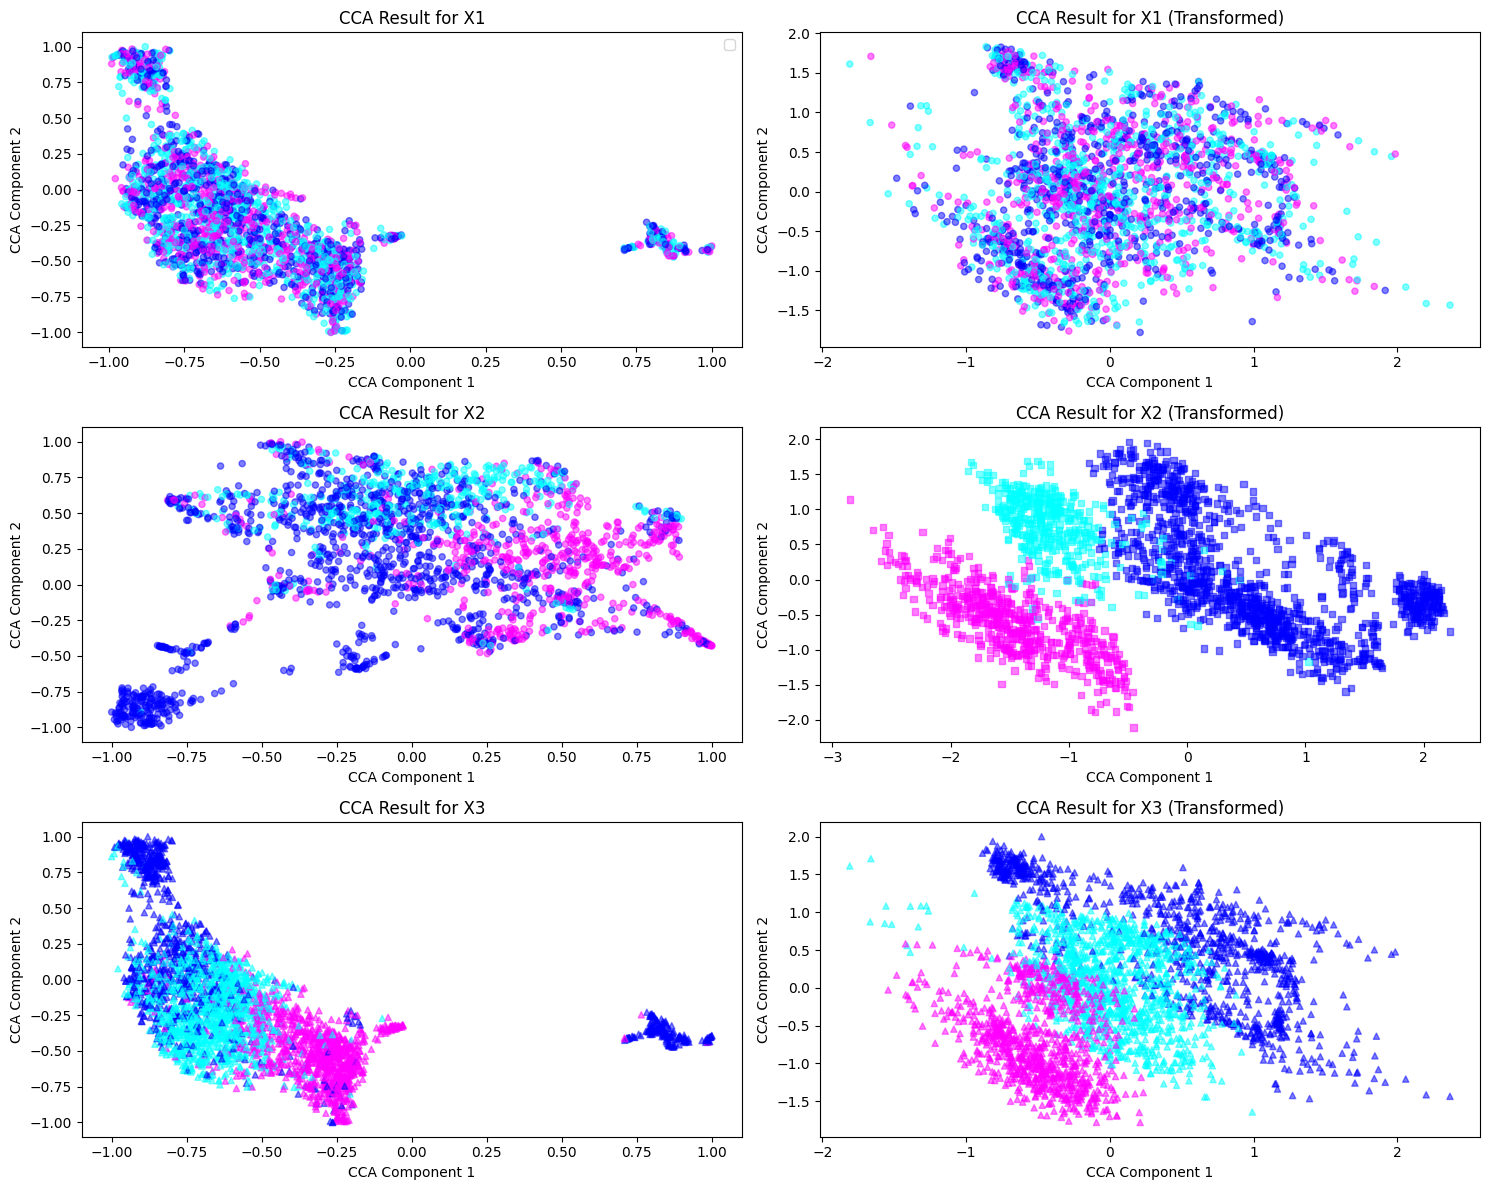

In [136]:
print(X_c.shape)
import matplotlib.pyplot as plt


#X2_tsne = TSNE(n_components=3,perplexity=10, random_state=42).fit_transform(X2_pca[:,0:30])
color_mapping = {
    0: 'blue',
    1: 'red',
    2: 'green',
    3: 'yellow',
    4: 'orange',
    5: 'purple',
    6: 'brown',
    7: 'pink',
    8: 'gray',
    9: 'cyan',
    10: 'magenta',
    11: 'cyan',
    12: 'blue',
    13: 'red',
    14: 'green',
    15: 'yellow'
}

# 假设 X_c 和 Y_c 是 CCA 转换后的结果
# 在这个示例中，假设 X_c 和 Y_c 都是二维数据

plt.figure(figsize=(15, 12))

# 绘制 X1 的散点图
plt.subplot(3, 2, 1)
scatter = plt.scatter(X_1_umap_results.iloc[:, 0], X_1_umap_results.iloc[:, 1],
                     # c=[color_mapping[category] for category in data1_leiden_str[selected_indices].astype(int)],
                      c=[color_mapping[category] for category in X1_label],
                      s=20, alpha=0.5)
unique_categories = np.unique(data1_leiden_str[selected_indices].astype(int))
legend_labels = [f'Category {cat}' for cat in unique_categories]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)
plt.title('CCA Result for X1')
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')


# 绘制 X1 转换后的散点图
plt.subplot(3, 2, 2)
plt.scatter(X_c.iloc[:, 0], X_c.iloc[:, 1], 
          #  c= [color_mapping[category] for category in data1_leiden_str[selected_indices].astype(int)], 
            c= [color_mapping[category] for category in X1_label],
            s=20, alpha=0.5)
plt.title('CCA Result for X1 (Transformed)')
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')

# 绘制 X2 的散点图
plt.subplot(3, 2, 3)
plt.scatter(X_2_umap_results.iloc[:, 0], X_2_umap_results.iloc[:, 1], 
           # c=[color_mapping[category] for category in data2_leiden_str.astype(int)],
            c= [color_mapping[category] for category in X2_label],
            s=20, alpha=0.5)
plt.title('CCA Result for X2')
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')

# 绘制 X2 转换后的散点图
plt.subplot(3, 2, 4)
plt.scatter(Y_c.iloc[:, 0], Y_c.iloc[:, 1], 
          #  c=[color_mapping[category] for category in data2_leiden_str.astype(int)], 
             c= [color_mapping[category] for category in X2_label],
            s=20, alpha=0.5, marker='s')
plt.title('CCA Result for X2 (Transformed)')
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')

# 绘制 X3 的散点图
plt.subplot(3, 2, 5)
plt.scatter(X_3_umap_results.iloc[:, 0], X_3_umap_results.iloc[:, 1], 
           # c=[color_mapping[category] for category in data1_leiden_str.astype(int)],
             c= [color_mapping[category] for category in X3_label],
            s=20, alpha=0.5, marker='^')
plt.title('CCA Result for X3')
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')

# 绘制 X3 转换后的散点图
plt.subplot(3, 2, 6)
plt.scatter(Z_c.iloc[:, 0], Z_c.iloc[:, 1], 
          #  c=[color_mapping[category] for category in data1_leiden_str.astype(int)] , 
             c= [color_mapping[category] for category in X3_label],
            s=20, alpha=0.5, marker='^')
plt.title('CCA Result for X3 (Transformed)')
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')

plt.tight_layout()
plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\m3_UMAP_CCA.pdf")
plt.show()

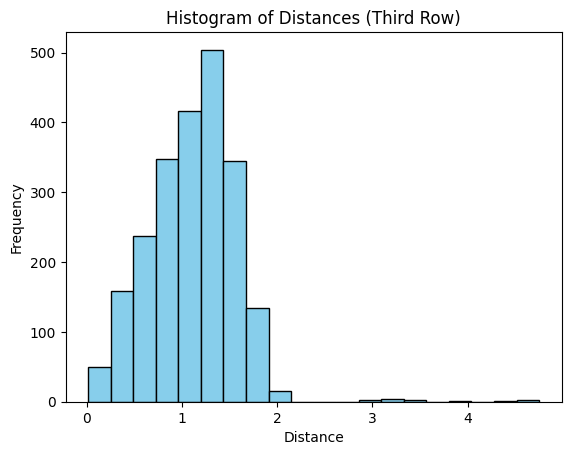

C:\Users\28123\AppData\Local\Temp\ipykernel_12340\1715769847.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_C_['spatial_ID'] = Y_C_.index
C:\Users\28123\AppData\Local\Temp\ipykernel_12340\1715769847.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_['matabolic_ID'] = Z_C_.index
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(3447,) (3447,)
(2175,)
(2204,)
            0         1         2         3         4         5         6   \
1752 -0.521672  0.564260  0.297228  1.330469 -0.265373  0.360388 -0.514724   
1993  0.328997  0.827225 -0.083583 -0.144467  0.384709  0.288659  0.522536   
1373  0.386724  0.586312 -0.094865  0.166309  0.263254  0.165510  0.642148   
180   0.343783  0.399381  0.140690  0.076999 -0.004338 -0.072602  0.531737   
1632  1.944321 -0.139802 -0.038955  0.751193  2.220422 -1.509385  0.942339   

            7         8         9   ...   25   26   27   28   29   30   31  \
1752 -0.368260  0.593326  0.820290  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1993 -0.371695 -0.285536 -0.087152  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1373 -0.176949  0.122055  0.371432  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
180  -0.294450  0.322725  0.784536  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1632  0.152459  1.545487  2.249697  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       32   33   34  
1752  0.

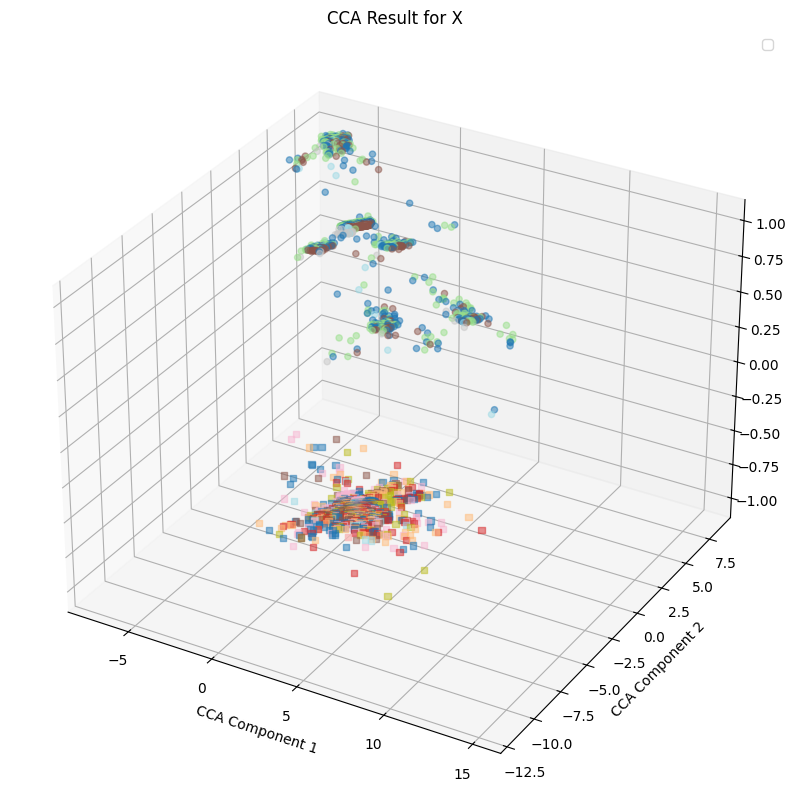

In [232]:
####select nearst neighbour groups of sample pairs between X1 and X3
####
dist_min = 2 ## min euclidean distance
from scipy.spatial.distance import cdist
distances = cdist(data3_spatial_results, data2_spatial_results, metric='euclidean')
dist_df = pd.DataFrame(distances)
dt_describe = dist_df.describe()
plt.hist(dt_describe.iloc[3,], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Distances (Third Row)')
plt.show()
###############找出Y_C(spatial)周围dist_min以内的Z_C(metabolic)点
row_indices, col_indices = np.where(distances <dist_min)
unique_row_indices = np.unique(row_indices)
unique_col_indices = np.unique(col_indices)
#############plot
####Z_C is metablic and is at 1
print(row_indices.shape, col_indices.shape)
print(unique_row_indices.shape)
print(unique_col_indices.shape)
print(Y_c.iloc[col_indices,].head())
print(Z_c.iloc[row_indices,].head())
Y_C_=Y_c.iloc[col_indices,]
Y_C_['spatial_ID'] = Y_C_.index
Y_C_=Y_C_.reset_index()
Y_C_["spatial_cluster"] = data2_leiden_str[col_indices].astype(int)
Y_C_["spatial.CCA.Z"] = -1
Y_C_=Y_C_.drop(columns=['index'])
Y_C_=Y_C_.rename(columns={0: "spatial.CCA.X", 1:"spatial.CCA.Y"})

Z_C_=Z_c.iloc[row_indices,]
Z_C_['matabolic_ID'] = Z_C_.index
Z_C_=Z_C_.reset_index()
Z_C_["matabolic_cluster"] = data1_leiden_str[row_indices].astype(int)
Z_C_=Z_C_.drop(columns=['index'])
Z_C_["matabolic.CCA.Z"] = 1
Z_C_=Z_C_.rename(columns={0: "metabolic.CCA.X", 1:"metabolic.CCA.Y"})

print(Y_C_.head())
print(Z_C_.head())
pairs = pd.concat([Y_C_,Z_C_],axis=1)
#pairs["distance"] = dist_df.iloc[row_indices,col_indices].values.diagonal()  //diagonal要求内存过大
print(pairs.head())

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(Z_c.iloc[unique_row_indices, 0], Z_c.iloc[unique_row_indices, 1],zs=1, c=data1_leiden_str[unique_row_indices].astype(int), cmap='tab20', s=20, alpha=0.5)
plt.scatter(Y_c.iloc[:, 0], Y_c.iloc[:, 1],zs=-1, c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5,marker='s')
#for i in range(0,pairs.shape[0]):
#    plt.plot(pairs.iloc[i,[0,5]], pairs.iloc[i,[1,6]], pairs.iloc[i,[4,9]], 'gray', linewidth=0.2)
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')
plt.title('CCA Result for X')
plt.legend()
plt.show()


In [233]:
import pandas as pd

def calculate_simpson_index(values):
    total_count = len(values)
    unique_values = set(values)
    simpson_index = 1 - sum((values.count(value) / total_count) ** 2 for value in unique_values)
    return simpson_index

def main(df):
    # 保存每个 X1 中值对应的 X2 中值的列表
    x1_x2_lists = df.groupby('spatial_ID')['matabolic_cluster'].apply(list).reset_index()

    # 计算每个 X1 中值的辛普森指数
    simpson_indices = x1_x2_lists['matabolic_cluster'].apply(calculate_simpson_index)

    # 保存每个 X1 中值对应的 X2 中出现频率最高的值
    max_x2_values = x1_x2_lists['matabolic_cluster'].apply(lambda x: max(set(x), key=x.count))

    # 生成新的 DataFrame
    new_df = pd.DataFrame({'spatial_ID': x1_x2_lists['spatial_ID'], 'Most_freq_metabolic_cluster': max_x2_values, 'Simpson_Index': simpson_indices})

    # 合并 X3 列
    new_df = pd.merge(new_df, df[['spatial_ID',"spatial_cluster"]].drop_duplicates(), on='spatial_ID', how='left')

    return new_df

# 示例输入数据
data = pairs
df = pd.DataFrame(data)

# 调用主函数
result_df = main(df)
print("新的 DataFrame:")
print(result_df)


新的 DataFrame:
      spatial_ID  Most_freq_metabolic_cluster  Simpson_Index  spatial_cluster
0              0                            3            0.0                1
1              1                            2            0.0                5
2              2                            2            0.0                2
3              3                            3            0.0                1
4              4                            3            0.0                5
...          ...                          ...            ...              ...
2199        2215                            1            0.5                4
2200        2216                            2            0.0                0
2201        2217                            1            0.0                1
2202        2218                            3            0.0                5
2203        2219                            1            0.0                3

[2204 rows x 4 columns]


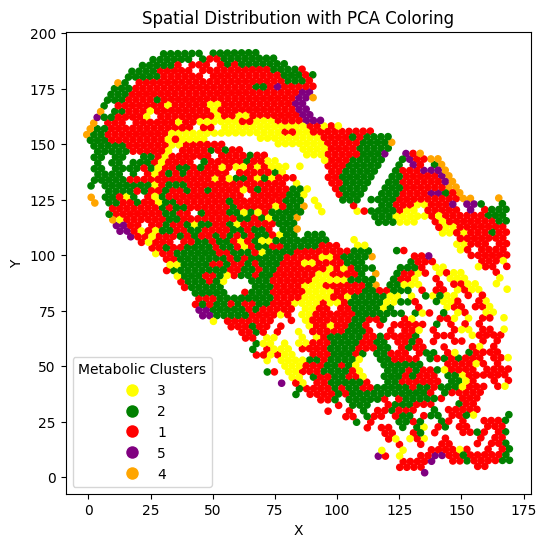

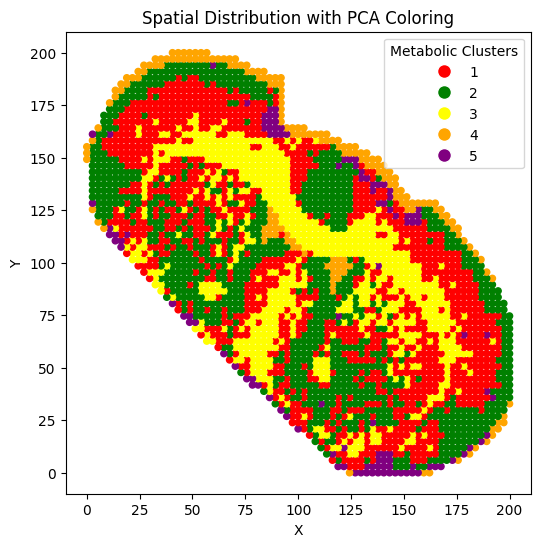

In [234]:
plt.figure(figsize=(6, 6))
plt.scatter(data2_spatial_results.iloc[result_df[result_df["Simpson_Index"]<1.1]["spatial_ID"].tolist(), 0],data2_spatial_results.iloc[result_df[result_df["Simpson_Index"]<1.1]["spatial_ID"].tolist(), 1],
            c=[color_mapping[category] for category in result_df[result_df["Simpson_Index"]<1]["Most_freq_metabolic_cluster"].tolist()], s=20, alpha=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
unique_categories = result_df["Most_freq_metabolic_cluster"].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[cat], markersize=10) for cat in unique_categories]
plt.legend(handles, unique_categories, title="Metabolic Clusters")
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\no_anchor_merge.pdf")
plt.show()
plt.figure(figsize=(6, 6))
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1], c=[color_mapping[category] for category in data1_leiden_str.astype(int)], s=20, alpha=1)
plt.xlabel('X')
plt.ylabel('Y')
unique_categories = np.unique(data1_leiden_str.astype(int))
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[cat], markersize=10) for cat in unique_categories]
plt.legend(handles, unique_categories, title="Metabolic Clusters")
plt.title('Spatial Distribution with PCA Coloring')
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\metabolic__.pdf")
plt.show()

C:\Users\28123\AppData\Local\Temp\ipykernel_12340\1096991620.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1],  c=[color_mapping[category] for category in data1_leiden_str.astype(int)], cmap='tab20', s=20, alpha=1)


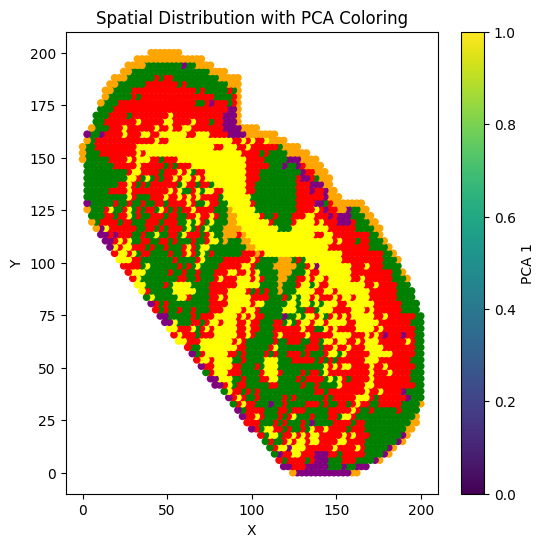

C:\Users\28123\AppData\Local\Temp\ipykernel_12340\1096991620.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data2_spatial_results.iloc[:, 0], data2_spatial_results.iloc[:, 1],  c=[color_mapping[category] for category in data2_leiden_str.astype(int)], cmap='tab20', s=20, alpha=1)


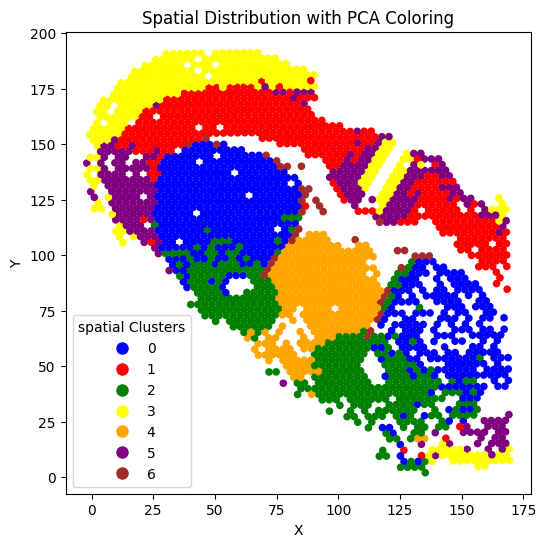

In [235]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1],  c=[color_mapping[category] for category in data1_leiden_str.astype(int)], cmap='tab20', s=20, alpha=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()
plt.figure(figsize=(6, 6))
plt.scatter(data2_spatial_results.iloc[:, 0], data2_spatial_results.iloc[:, 1],  c=[color_mapping[category] for category in data2_leiden_str.astype(int)], cmap='tab20', s=20, alpha=1)
plt.xlabel('X')
plt.ylabel('Y')
unique_categories = np.unique(data2_leiden_str.astype(int))
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[cat], markersize=10) for cat in unique_categories]
plt.legend(handles, unique_categories, title="spatial Clusters")
plt.title('Spatial Distribution with PCA Coloring')
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\spatial__.pdf")
plt.show()

In [1]:
####select nearst neighbour of sample pairs between X1 and X3
####
print(Z_c.shape, Y_c.shape)
from scipy.spatial.distance import cdist
distances = cdist(data3_spatial_results, data2_spatial_results, metric='euclidean')
dist_df = pd.DataFrame(distances)
print(dist_df.shape)
min_row_indices = dist_df.idxmin()
print(Z_c.shape, Y_c.shape)
###############找出Y_C(spatial)周围dist_min以内的Z_C(metabolic)点
Y_C_ = Y_c.iloc[:,:]
Y_C_['spatial_ID'] = Y_C_.index
Y_C_ = Y_C_.reset_index()
Y_C_["spatial_cluster"] = data2_leiden_str.astype(int)
Y_C_["spatial.CCA.Z"] = -1
Y_C_ = Y_C_.drop(columns=['index'])
Y_C_ = Y_C_.rename(columns={0: "spatial.CCA.X", 1:"spatial.CCA.Y"})
print(Z_c.shape, Y_c.shape)
Z_C_=Z_c.iloc[min_row_indices,]
Z_C_['matabolic_ID'] = Z_C_.index
Z_C_=Z_C_.reset_index()
Z_C_["matabolic_cluster"] = data1_leiden_str[min_row_indices].astype(int)
Z_C_=Z_C_.drop(columns=['index'])
Z_C_["matabolic.CCA.Z"] = 1
Z_C_=Z_C_.rename(columns={0: "metabolic.CCA.X", 1:"metabolic.CCA.Y"})
pairs = pd.concat([Y_C_,Z_C_],axis=1)
#pairs["distance"] = dist_df.iloc[row_indices,col_indices].values.diagonal()  //diagonal要求内存过大
print(pairs.head())

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(Z_c.iloc[unique_row_indices, 0], Z_c.iloc[unique_row_indices, 1],zs=1, c=data1_leiden_str[unique_row_indices].astype(int), cmap='tab20', s=20, alpha=0.5)
plt.scatter(Y_c.iloc[:, 0], Y_c.iloc[:, 1],zs=-1, c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5,marker='s')
#for i in range(0,pairs.shape[0]):
#    plt.plot(pairs.iloc[i,[0,5]], pairs.iloc[i,[1,6]], pairs.iloc[i,[4,9]], 'gray', linewidth=0.2)
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')
plt.title('CCA Result for X')
plt.legend()
plt.show()

NameError: name 'Z_c' is not defined

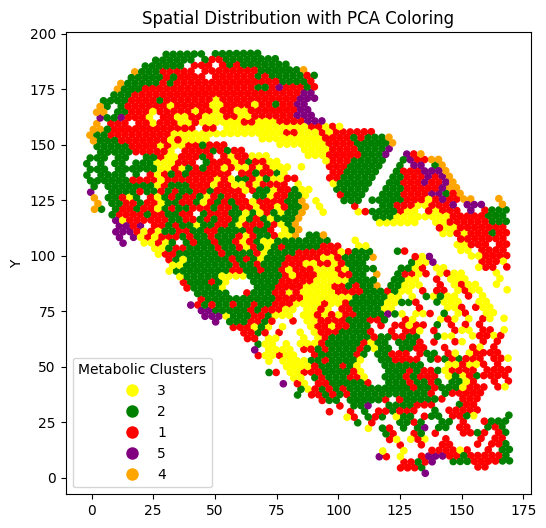

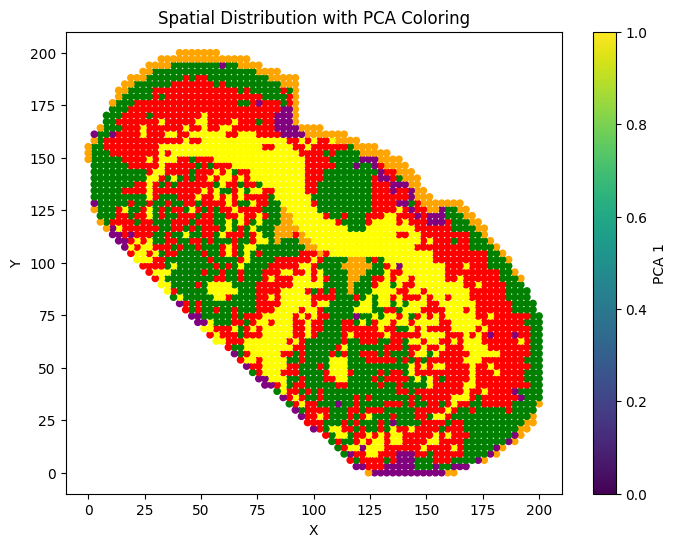

In [239]:
plt.figure(figsize=(6, 6))
plt.scatter(data2_spatial_results.iloc[:, 0],data2_spatial_results.iloc[:, 1], 
            c=[color_mapping[category] for category in pairs["matabolic_cluster"].tolist()], s=20, alpha=1)
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
unique_categories = pairs["matabolic_cluster"].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[cat], markersize=10) for cat in unique_categories]
plt.legend(handles, unique_categories, title="Metabolic Clusters")
plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\no_anchor_merge_nearst_pair.pdf")
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1], c=[color_mapping[category] for category in data1_leiden_str.astype(int)], s=20, alpha=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()

In [2]:
###### find transcript-metaboic pairs anchors by filtering: 
######1/simpson index less than 0.2 2/Most_freq_metabolic_cluster==matabolic_cluster
#print(result_df.head)
#print(pairs.head)
merged_df = pd.merge(result_df, pairs, on='spatial_ID', how='inner')
merged_df = pd.DataFrame(merged_df)
merged_df = merged_df[(merged_df['Simpson_Index'] < 0.001) & (merged_df['Most_freq_metabolic_cluster'] == merged_df['matabolic_cluster'])]
merged_df = merged_df.drop_duplicates(subset="matabolic_ID")
print(merged_df["spatial_ID"])
print(merged_df)
plt.figure(figsize=(6, 6))
plt.scatter(data2_spatial_results.iloc[merged_df["spatial_ID"], 0],data2_spatial_results.iloc[merged_df["spatial_ID"], 1], 
            c=[color_mapping[category] for category in merged_df["matabolic_cluster"].tolist()], s=20, alpha=1)
plt.ylabel('Y')
plt.title('anchors')
unique_categories = merged_df["matabolic_cluster"].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[cat], markersize=10) for cat in unique_categories]
plt.legend(handles, unique_categories, title="Metabolic Clusters")
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\anchor_spatial.pdf")
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(data3_spatial_results.iloc[merged_df["matabolic_ID"], 0],data3_spatial_results.iloc[merged_df["matabolic_ID"], 1], 
            c=[color_mapping[category] for category in merged_df["matabolic_cluster"].tolist()], s=20, alpha=1)
plt.ylabel('Y')
plt.title('anchors')
unique_categories = merged_df["matabolic_cluster"].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[cat], markersize=10) for cat in unique_categories]
plt.legend(handles, unique_categories, title="Metabolic Clusters")
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\anchor_metabolic.pdf")
plt.show()


NameError: name 'pd' is not defined

In [243]:
scaler = MinMaxScaler(feature_range=(-1, 1))
DF1 = convert_to_array(adata2.X)
DF1 = pd.DataFrame(DF1)
DF1 = tpm_normalize(DF1)
DF1 = np.log2(DF1 + 1)
DF1 = scaler.fit_transform(DF1)
DF1 = pd.DataFrame(DF1)

DF2 = convert_to_array(adata1.X)
DF2 = pd.DataFrame(DF2)
DF2 = scaler.fit_transform(DF2)
DF2 = pd.DataFrame(DF2)

print(DF1.shape,DF2.shape)
spatial_ID_list = merged_df['spatial_ID'].tolist()
metabolic_ID_list = merged_df['matabolic_ID'].tolist()

# 从 DF1 和 DF2 中提取对应的样本
spatial_samples = DF1.loc[spatial_ID_list,:]
index_strings = adata2.var.index.astype(str)
column_mapping = {old_name: new_name for old_name, new_name in zip(spatial_samples.columns, index_strings)}
spatial_samples.rename(columns=column_mapping, inplace=True)
rowindex = spatial_samples.shape[0]
spatial_samples.index = range(rowindex)

metabolic_samples = DF2.loc[metabolic_ID_list,:]
rowindex = metabolic_samples.shape[0]
index_strings = adata1.var.index.astype(str)
column_mapping = {old_name: new_name for old_name, new_name in zip(metabolic_samples.columns, index_strings)}
metabolic_samples.rename(columns=column_mapping, inplace=True)
metabolic_samples.index = range(rowindex)

print(spatial_samples.shape,metabolic_samples.shape,pd.concat([spatial_samples, metabolic_samples], axis=0).shape)
# 计算特征之间的相关性

(2220, 15630) (3084, 3658)
(1568, 15630) (1568, 3658) (3136, 19288)


In [244]:
correlation_matrix = pd.concat([spatial_samples, metabolic_samples], axis=1)
correlation_matrix = correlation_matrix.corr()
# 显示相关性矩阵
print("DF1 列变量与 DF2 列变量之间的相关性矩阵：")

# 显示 DF3
#print(DF3)

DF1 列变量与 DF2 列变量之间的相关性矩阵：


(15630, 3658)


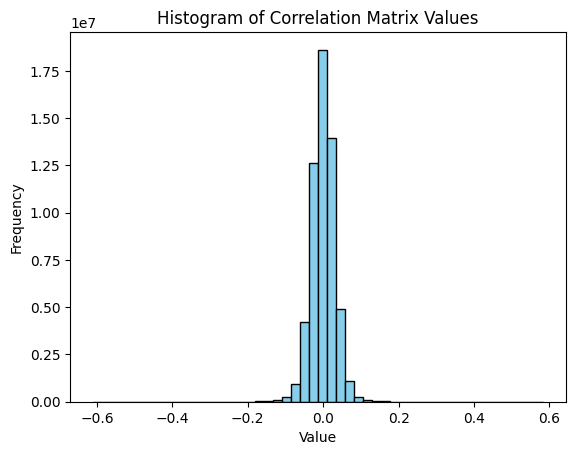

In [245]:
correlation_matrix2 = correlation_matrix.iloc[:15630, -3658:]
print(correlation_matrix2.shape)

values = correlation_matrix2.values.flatten()
plt.hist(values, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Correlation Matrix Values')
plt.xlabel('Value')
plt.ylabel('Frequency')

# 显示图形
plt.show()
high_correlation_spatial = []
high_correlation_metabolic = []



In [246]:
import pandas as pd
import numpy as np

# Example correlation matrix with NaN values

# Flatten the correlation matrix and keep track of the row and column indices, excluding NaNs
flattened = correlation_matrix2.values.flatten()
non_nan_indices = ~np.isnan(flattened)
flattened_non_nan = flattened[non_nan_indices]
original_indices = np.dstack(np.unravel_index(np.where(non_nan_indices)[0], correlation_matrix2.shape))[0]

# Sort the non-NaN flattened array to find the top 20 highest values
sorted_indices = np.argsort(flattened_non_nan)[::-1]
top_n = 30
top_indices = original_indices[sorted_indices[:top_n]]

# Retrieve the corresponding row and column indices
top_rows = top_indices[:, 0]
top_cols = top_indices[:, 1]

# Get the top 20 highest values
top_values = flattened_non_nan[sorted_indices[:top_n]]

# Convert to lists if needed
top_rows = list(top_rows)
top_cols = list(top_cols)
top_values = list(top_values)

# Display results
print("Top 20 highest correlation values (excluding NaNs):")
for i in range(len(top_values)):
    print(f"Value: {top_values[i]}, Row: {top_rows[i]}, Column: {top_cols[i]}")

# Optionally, convert to a DataFrame for easier viewing
top_correlations_df = pd.DataFrame({
    'Value': top_values,
    'Row': top_rows,
    'Column': top_cols
})

print("\nTop 20 highest correlation values in DataFrame format:")
print(top_correlations_df)


Top 20 highest correlation values (excluding NaNs):
Value: 0.584118929129718, Row: 8836, Column: 1037
Value: 0.5823922454896044, Row: 10864, Column: 36
Value: 0.578028137180237, Row: 8836, Column: 36
Value: 0.5761137118881168, Row: 8836, Column: 1036
Value: 0.5718944903453833, Row: 10864, Column: 37
Value: 0.5667872492440095, Row: 8836, Column: 37
Value: 0.5649051610184224, Row: 10864, Column: 1037
Value: 0.5646585602921445, Row: 8836, Column: 2595
Value: 0.5584256073200005, Row: 10864, Column: 1036
Value: 0.5564156011116655, Row: 10312, Column: 36
Value: 0.5544982648723122, Row: 7925, Column: 36
Value: 0.5538383453279423, Row: 10864, Column: 34
Value: 0.5525685927745166, Row: 8836, Column: 34
Value: 0.5491417831711574, Row: 10312, Column: 1037
Value: 0.5487489881598763, Row: 10864, Column: 2595
Value: 0.5465386111037311, Row: 743, Column: 36
Value: 0.5441158282806625, Row: 10864, Column: 35
Value: 0.5414002001617958, Row: 8836, Column: 35
Value: 0.5411087858598461, Row: 10312, Column:

In [247]:
scaler = MinMaxScaler(feature_range=(-1, 1))

metabolic_select_high_corr_variant = convert_to_array(adata1.X)
metabolic_select_high_corr_variant = pd.DataFrame(metabolic_select_high_corr_variant)
metabolic_select_high_corr_variant = scaler.fit_transform(metabolic_select_high_corr_variant)
metabolic_select_high_corr_variant = pd.DataFrame(metabolic_select_high_corr_variant)
metabolic_select_high_corr_variant = metabolic_select_high_corr_variant.iloc[:,top_cols]
#metabolic_select_high_corr_variant = pd.concat([X_3_umap_results.drop(X_3_umap_results.columns[2], axis=1), metabolic_select_high_corr_variant], axis=1)
metabolic_select_high_corr_variant = pd.concat([X_3_umap_results, metabolic_select_high_corr_variant], axis=1)
#metabolic_select_high_corr_variant = pd.concat([data3_spatial_results, metabolic_select_high_corr_variant], axis=1)
print(metabolic_select_high_corr_variant.shape)
metabolic_select_high_corr_variant_X1 = metabolic_select_high_corr_variant.iloc[selected_indices,]

spatial_select_high_corr_variant = convert_to_array(adata2.X)
spatial_select_high_corr_variant = pd.DataFrame(spatial_select_high_corr_variant)
spatial_select_high_corr_variant = scaler.fit_transform(spatial_select_high_corr_variant)
spatial_select_high_corr_variant = pd.DataFrame(spatial_select_high_corr_variant)
spatial_select_high_corr_variant = spatial_select_high_corr_variant.iloc[:,top_rows]
#spatial_select_high_corr_variant = pd.concat([X_2_umap_results.drop(X_2_umap_results.columns[2], axis=1), spatial_select_high_corr_variant], axis=1)
spatial_select_high_corr_variant = pd.concat([X_2_umap_results, spatial_select_high_corr_variant], axis=1)
#spatial_select_high_corr_variant = pd.concat([data2_spatial_results, spatial_select_high_corr_variant], axis=1)

print(spatial_select_high_corr_variant.shape)



(3084, 35)
(2220, 35)


In [248]:
cca = CCA(n_components=35)
cca.fit(spatial_select_high_corr_variant,metabolic_select_high_corr_variant_X1)
X_c = cca.transform(metabolic_select_high_corr_variant_X1)
Y_c = cca.transform(spatial_select_high_corr_variant)
Z_c = cca.transform(metabolic_select_high_corr_variant)

X_c=pd.DataFrame(X_c)
Y_c=pd.DataFrame(Y_c)
Z_c=pd.DataFrame(Z_c)

I:\mutiomics\pythonProject\.venv\lib\site-packages\sklearn\cross_decomposition\_pls.py:305: UserWarning: Y residual is constant at iteration 26
  warnings.warn(f"Y residual is constant at iteration {k}")


(3084, 35) (2220, 35)
(3084, 2220)
(3084, 35) (2220, 35)
(3084, 35) (2220, 35)


C:\Users\28123\AppData\Local\Temp\ipykernel_12340\808405300.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_['matabolic_ID'] = Z_C_.index
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


   spatial.CCA.X  spatial.CCA.Y         2         3         4         5  \
0       0.633642       0.696608  0.364747 -0.302969  0.237161  0.400186   
1       0.226227       0.284855  0.850225  0.277142  0.546613 -0.473253   
2      -0.303433      -0.888716 -0.238431  0.795793  0.011221  0.401991   
3      -0.213770       0.728173  0.778125  0.390725  0.230429 -0.080215   
4       0.426833       0.251375  0.459090 -0.110358  0.889964  0.149942   

          6         7         8         9  ...   28   29   30   31   32   33  \
0  0.781061 -0.119017 -0.484154  0.121158  ...  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.019123  0.050764  0.153548  0.334926  ...  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.658985  0.837277  2.024533  0.418982  ...  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.185808  0.224479  0.978499 -0.091597  ...  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.162151 -0.390985 -0.100232 -0.013962  ...  0.0  0.0  0.0  0.0  0.0  0.0   

    34  matabolic_ID  matabolic_cluster  matabolic.CCA.Z  
0  0.0   

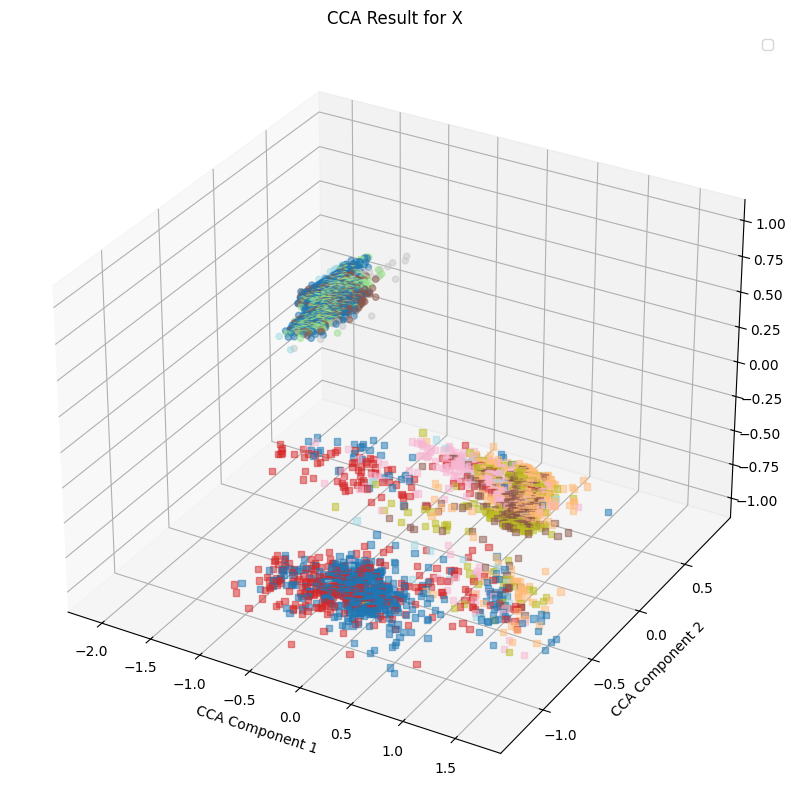

In [249]:
####select nearst neighbour of sample pairs between X1 and X3
####
print(Z_c.shape, Y_c.shape)
from scipy.spatial.distance import cdist
distances = cdist(Z_c, Y_c, metric='euclidean')
dist_df = pd.DataFrame(distances)
print(dist_df.shape)
min_row_indices = dist_df.idxmin()
print(Z_c.shape, Y_c.shape)
###############找出Y_C(spatial)周围dist_min以内的Z_C(metabolic)点
Y_C_ = Y_c.iloc[:,:]
Y_C_['spatial_ID'] = Y_C_.index
Y_C_ = Y_C_.reset_index()
Y_C_["spatial_cluster"] = data2_leiden_str.astype(int)
Y_C_["spatial.CCA.Z"] = -1
Y_C_ = Y_C_.drop(columns=['index'])
Y_C_ = Y_C_.rename(columns={0: "spatial.CCA.X", 1:"spatial.CCA.Y"})
print(Z_c.shape, Y_c.shape)
Z_C_=Z_c.iloc[min_row_indices,]
Z_C_['matabolic_ID'] = Z_C_.index
Z_C_=Z_C_.reset_index()
Z_C_["matabolic_cluster"] = data1_leiden_str[min_row_indices].astype(int)
Z_C_=Z_C_.drop(columns=['index'])
Z_C_["matabolic.CCA.Z"] = 1
Z_C_=Z_C_.rename(columns={0: "metabolic.CCA.X", 1:"metabolic.CCA.Y"})
pairs = pd.concat([Y_C_,Z_C_],axis=1)
#pairs["distance"] = dist_df.iloc[row_indices,col_indices].values.diagonal()  //diagonal要求内存过大
print(pairs.head())

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(Z_c.iloc[unique_row_indices, 0], Z_c.iloc[unique_row_indices, 1],zs=1, c=data1_leiden_str[unique_row_indices].astype(int), cmap='tab20', s=20, alpha=0.5)
plt.scatter(Y_c.iloc[:, 0], Y_c.iloc[:, 1],zs=-1, c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5,marker='s')
#for i in range(0,pairs.shape[0]):
#    plt.plot(pairs.iloc[i,[0,5]], pairs.iloc[i,[1,6]], pairs.iloc[i,[4,9]], 'gray', linewidth=0.2)
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')
plt.title('CCA Result for X')
plt.legend()
plt.show()

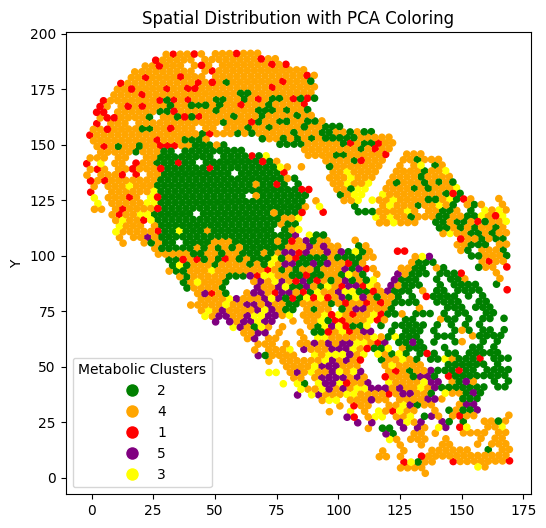

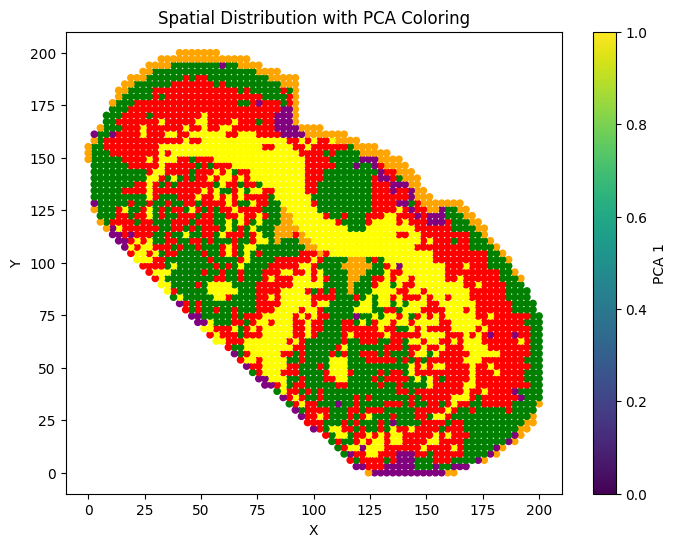

In [250]:
plt.figure(figsize=(6, 6))
plt.scatter(data2_spatial_results.iloc[:, 0],data2_spatial_results.iloc[:, 1], 
            c=[color_mapping[category] for category in pairs["matabolic_cluster"].tolist()], s=20, alpha=1)
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
unique_categories = pairs["matabolic_cluster"].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[cat], markersize=10) for cat in unique_categories]
plt.legend(handles, unique_categories, title="Metabolic Clusters")
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\with_anchor_merge_nearst_pair.pdf")
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1], c=[color_mapping[category] for category in data1_leiden_str.astype(int)], s=20, alpha=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()

In [185]:
pairs

spatial.CCA.X  spatial.CCA.Y         2         3         4         5  \
0          0.494256      -0.504832  0.625657  0.300058 -0.458966 -0.439866   
1         -0.887578      -0.332415  0.408579  1.454493  0.860583  1.423433   
2         -0.433567       1.345740  0.765258  1.501434  2.000345 -0.427325   
3          0.523894       0.725983 -0.297575  0.493060  0.213488  0.638642   
4         -0.824437      -1.190159  2.355432 -0.865168  0.840308  0.859602   
...             ...            ...       ...       ...       ...       ...   
2215      -2.170424      -0.039575  1.706355 -2.260414 -0.850896 -0.782193   
2216      -0.050600      -0.580854  0.790547 -0.286257  1.202125  0.256563   
2217      -0.163246      -0.912917  1.625030 -0.492963 -0.061933  0.330417   
2218      -0.912044      -0.521665  1.795679  0.143337  0.407669  0.033152   
2219       0.562286      -0.938043 -0.113647 -0.257516 -0.631041  0.783337   

             6         7         8         9  ...   28   29   30   31   32  \
0     0.719116  0.091170  0.645654 -0.501346  ...  0.0  0.0  0.0  0.0  0.0   
1    -0.681755 -1.121683  0.620281 -0.398723  ...  0.0  0.0  0.0  0.0  0.0   
2    -0.337694 -1.027731  0.409064  0.468129  ...  0.0  0.0  0.0  0.0  0.0   
3     1.709661  0.333936  0.772804  0.515693  ...  0.0  0.0  0.0  0.0  0.0   
4    -1.044522  0.484181 -0.437281  0.864472  ...  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
2215  1.208808  0.525148 -1.007666  0.525574  ...  0.0  0.0  0.0  0.0  0.0   
2216 -0.362798  0.285994 -0.761669  0.686488  ...  0.0  0.0  0.0  0.0  0.0   
2217 -1.081320  0.616644 -0.596154  0.275997  ...  0.0  0.0  0.0  0.0  0.0   
2218 -0.982845  0.408645  0.960589 -0.099113  ...  0.0  0.0  0.0  0.0  0.0   
2219  0.028942 -0.214445  0.880490  0.339433  ...  0.0  0.0  0.0  0.0  0.0   

       33   34  matabolic_ID  matabolic_cluster  matabolic.CCA.Z  
0     0.0  0.0          1815                  1                1  
1     0.0  0.0          2593                  3                1  
2     0.0  0.0          1474                  3                1  
3     0.0  0.0          1884                  3                1  
4     0.0  0.0          1494                  3                1  
...   ...  ...           ...                ...              ...  
2215  0.0  0.0           426                  1                1  
2216  0.0  0.0          1580                  2                1  
2217  0.0  0.0          2632                  3                1  
2218  0.0  0.0          2264                  3                1  
2219  0.0  0.0          2675                  3                1  

[2220 rows x 76 columns]

In [186]:
pairs.to_csv("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m3\\pair.csv", index=False)